# Probabilistic selection of RCL size

In general, the increased exploration from randomly selecting the RCL length should lead to better solutions.  This may be at the cost of slightly increased run time i.e. might be better to run with a `max_iter` than `time_limit` when comparing with a fixed sized RCL.

In [1]:
import numpy as np
import sys

## `metapy` imports

In [2]:
# install metapy if running in Google Colab
if 'google.colab' in sys.modules:
    !pip install meta-py

In [3]:
from metapy.tsp import tsp_io as io
from metapy.tsp.euclidean import gen_matrix, plot_tour

from metapy.tsp.objective import OptimisedSimpleTSPObjective

from metapy.local_search.hill_climbing import (HillClimber,
                                               TweakTwoOpt, 
                                               SimpleTweak)

from metapy.tsp.grasp import (SemiGreedyConstructor, 
                              RandomRCLSizer, 
                              GRASP)

## Load problem

In [4]:
#load file
file_path = 'https://raw.githubusercontent.com/TomMonks/meta-py/main/data/st70.tsp'

#number of rows in the file that are meta_data
md_rows = 6

#read the coordinates
cities = io.read_coordinates(file_path, md_rows)
matrix = gen_matrix(cities, as_integer=True)

## Probabilistic Select

We have already seen the class for probablistic selection of the RCL size.  There are two hyper parameters: the upper and lower limit for the RCL size.  Each RCL size is then given an equal weighting in selection.

In [5]:
class RandomRCLSizer:
    '''
    Probabilitic selection of the RCL size: Uniform probability.
    '''
    def __init__(self, r_list, random_seed=None):
        '''
        Constructor
        
        Params:
        -------
        r_list: array-like
            a vector of RCL sizes e.g. [2, 3, 4, 5, 6]
            
        random_seed: int, optional (default=None)
            used to control sampling
        '''
        self.r_list = r_list
        self.rng = np.random.default_rng(random_seed)
        
    def get_size(self, size=None):
        '''
        Returns a randomly selected RCL size
        
        Returns:
        -------
        int
        '''
        return self.rng.choice(self.r_list, size=size)

In [6]:
## Running GRASP with a random RCL sizer

In [7]:
def get_grasp(tour, matrix, max_iter=50, rcl_min=2, rcl_max=15, 
              seeds=(None, None)):
    # objective function
    obj = OptimisedSimpleTSPObjective(-matrix)

    # Two-opt tweaks
    tweaker = TweakTwoOpt()

    # local search = first improvement hill climbing
    ls = HillClimber(obj, tour, tweaker)

    # semi-greedy constructor and RCL sizer
    sizer = RandomRCLSizer(np.arange(rcl_min, rcl_max), random_seed=seeds[0])
    constructor = SemiGreedyConstructor(sizer, tour, -matrix, 
                                        random_seed=seeds[1])

    # GRASP framework
    solver = GRASP(constructor, ls, max_iter=max_iter)
    
    return solver


Running GRASP with probablistic selection of RCL size

** GRASP OUTPUT ***
best cost:	-724.0
best solutions:
[ 0 35 22 15 46 36 57 49 50 64 63 10 55 66 47 53 32 59 51  9  4 52  5 40
 42 16 20 33 11 61 38 24 44 45 26 39 60  8 67 43 29 19 13 48 54 25  7 27
  2 31 41 17  3  1  6 18 23 14 56 34 69 28 12 30 68 37 58 21 62 65]


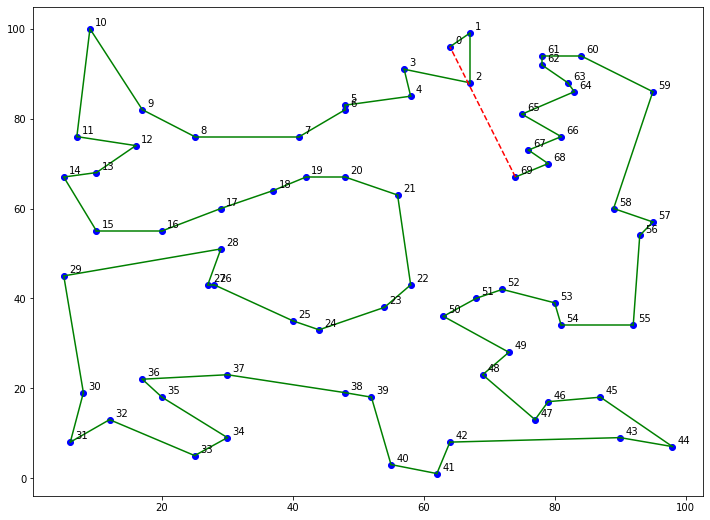

In [8]:
tour = np.arange(len(cities))
solver = get_grasp(tour, matrix, seeds=(42, 101))
print("\nRunning GRASP with probablistic selection of RCL size")
solver.solve()

print("\n** GRASP OUTPUT ***")
print(f"best cost:\t{solver.best}")
print("best solutions:")
print(solver.best_solution)
fig, ax = plot_tour(solver.best_solution, cities, figsize=(12,9))